In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
from xgcm import Grid

create ncfile for topo with ice front

In [2]:
ice_thick = xr.open_dataset('INPUT/ice_shelf.nc')
ice_thick

<xarray.Dataset>
Dimensions:  (ny: 40, nx: 240)
Dimensions without coordinates: ny, nx
Data variables:
    thick    (ny, nx) float64 ...
    area     (ny, nx) float64 ...

In [3]:
ice_thick_front = ice_thick

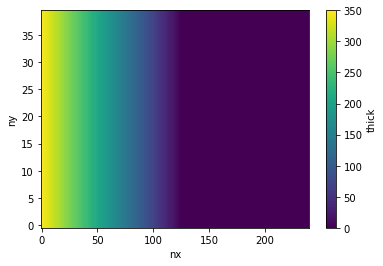

In [5]:
ice_thick_front.thick.plot()

In [10]:
ice_thick_front['thick'] = (ice_thick_front.thick.where(ice_thick_front.thick > 0)+200).fillna(0)

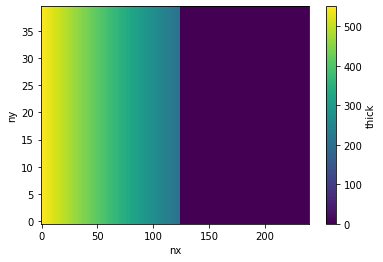

In [12]:
ice_thick_front.thick.plot()

In [13]:
ice_thick_front.to_netcdf('ice_shelf_front.nc')

after running with `THICKNESS_CONFIG = "ISOMIP"`

In [14]:
def make_thickness_file(filename):
    
    ic = xr.open_dataset('MOM_IC.nc')
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()


In [15]:
make_thickness_file('INPUT/thickness_simpleshelf2front_pfile.nc')

after running with `THICKNESS_CONFIG = "thickness_file"`

In [2]:
ave = False ## True means use 5 daily average rather than hourly prog
basee = '/Users/claireyung/mom6/MOM6-examples/ocean_only/seamount/'
def open_files(folder):
    base = basee + folder
    if ave:
        prog = xr.open_dataset(base + '/ave_prog.nc')
    else:
        prog = xr.open_dataset(base + '/prog.nc')
    ocean_static = xr.open_dataset(base + "/ocean_geometry.nc")
    return prog, ocean_static
def open_IC(folder):
    base = basee + folder
    IC = xr.open_dataset(base + '/MOM_IC.nc')
    return IC
def open_Initialstate(folder):
    base = basee + folder
    IC = xr.open_dataset(base + '/Initial_state.nc')
    return IC

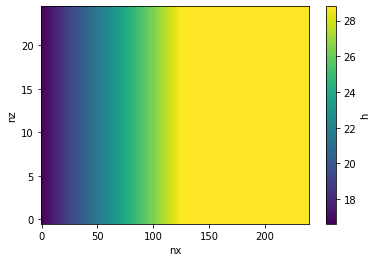

In [15]:
def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap,ymax):
    prog, ocean_static = open_files(label)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) 
    xi, yyi = np.meshgrid(xx[yy0,:], yi) 
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


In [ ]:
## Plot velocities
fig, axes = plt.subplots(ncols = 3, figsize = (16,4), dpi = 200)

label = 'simpleshelftest2icefront'
prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']), label = 'fixed') ## I saved all timesteps = 5 mins
axes[0].set_ylabel('maximum u speed (m/s)')
axes[0].set_xlabel('time (days)')
axes[0].set_title('Spurious Current')

# label = 'simpleshelftest2'
# prog, ocean_static = open_files(label)
# axes[0].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']), label = 'original')

# axes[0].set_yscale('log')
# axes[0].legend()
label = 'simpleshelftest2icefront'
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = -1
time = -1
ymax = 720
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(axes[1],x,time,0,IC.Salt-ideal_salt,"salinity anomaly \n",-5e-3,5e-3,cm.cm.balance,ymax)

plot(axes[2],x,time,0,prog.u,"u (m/s)",-0.0005,0.0005,cm.cm.balance,ymax)

axes[1].set_title('Salinity Anomaly from linear \n fit to centre of cell \n for original ALE initialisation')
axes[2].set_title('u velocities at t = 1 day \n for original ALE initialisation')

fig.subplots_adjust(wspace = 0.4)